The dataset is related to red and white variants of the Portuguese "Vinho Verde" wine. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

This dataset can be viewed as classification task. The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

Attribute Information

Input variables (based on physicochemical tests): 1 - fixed acidity 2 - volatile acidity 3 - citric acid 4 - residual sugar 5 - chlorides 6 - free sulfur dioxide 7 - total sulfur dioxide 8 - density 9 - pH 10 - sulphates 11 - alcohol Output variable (based on sensory data): 12 - quality (score between 0 and 10)

What might be an interesting thing to do, is to set an arbitrary cutoff for your dependent variable (wine quality) at e.g. 7 or higher getting classified as 'good/1' and the remainder as 'not good/0'. This allows you to practice with hyper parameter tuning on e.g. decision tree algorithms looking at the ROC curve and the AUC value.

You need to build a classification model.

Inspiration

Use machine learning to determine which physiochemical properties make a wine 'good'!

In [1]:
pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import zscore
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

In [4]:
df=pd.read_csv("winequality-red.csv")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [5]:
# removing outliers
z=np.abs(zscore(df))
df_n=df[(z<3).all(axis=1)]

Less than 10% data has been removed as outliers.

<AxesSubplot:>

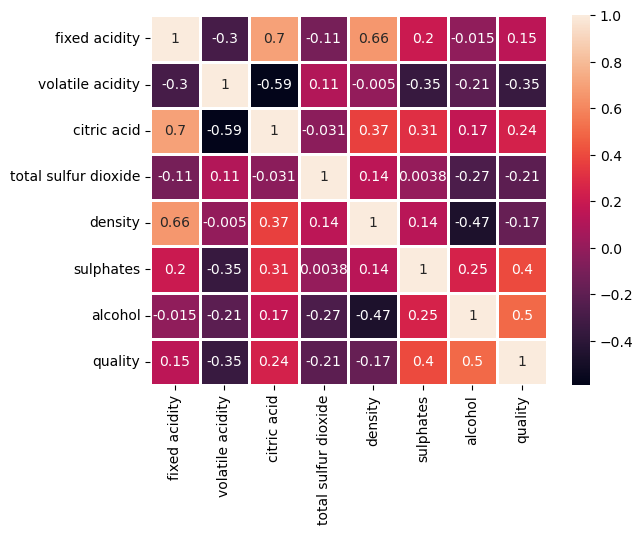

In [54]:
#to check multicolinearity

dfc=df_n.corr()
sns.heatmap(dfc, annot= True, linewidths=0.75)

In [7]:
#To remove multicolinearity.
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_cal():
    vif=pd.DataFrame()
    vif["VIF Factor"]=[variance_inflation_factor(df_n.iloc[:,:-1].values,i) for i in range(df_n.iloc[:,:-1].shape[1])]
    vif["features"]=df_n.iloc[:,:-1].columns
    print(vif)
vif_cal()

     VIF Factor              features
0     89.002451         fixed acidity
1     19.579511      volatile acidity
2      9.358017           citric acid
3      9.927999        residual sugar
4     18.125560             chlorides
5      7.003640   free sulfur dioxide
6      6.956718  total sulfur dioxide
7   1696.645871               density
8   1242.149186                    pH
9     31.740424             sulphates
10   141.935926               alcohol


In [8]:
# dropping columns chlorides,residual sugar, free sulfur dioxide and ph.
df_n.drop(["chlorides","pH","residual sugar","free sulfur dioxide"], inplace=True, axis=1)

In [9]:
df_n.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
total sulfur dioxide    float64
density                 float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [10]:
df_n.describe()

,fixed acidity,volatile acidity,citric acid,total sulfur dioxide,density,sulphates,alcohol,quality
count,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000
mean,8.310062,0.522950,0.265382,43.735355,0.996710,0.642584,10.421089,5.659545
std,1.646458,0.168531,0.190934,29.441284,0.001716,0.129801,1.021588,0.781605
min,5.000000,0.120000,0.000000,6.000000,0.991500,0.330000,8.500000,4.000000
25%,7.100000,0.390000,0.090000,21.000000,0.995600,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,36.000000,0.996700,0.620000,10.200000,6.000000
75%,9.200000,0.630000,0.420000,58.000000,0.997800,0.720000,11.100000,6.000000
max,13.500000,1.040000,0.790000,145.000000,1.002200,1.160000,13.600000,8.000000


Mean is more than median, so data is skewed.
Difference between 75th percentile and max is large, so outliers present.

In [11]:
df_n.skew()

fixed acidity           0.823934
volatile acidity        0.380659
citric acid             0.291297
total sulfur dioxide    1.183161
density                 0.055738
sulphates               0.891492
alcohol                 0.758958
quality                 0.407865
dtype: float64

In [12]:
df_n["total sulfur dioxide"]=np.log(df_n["total sulfur dioxide"])

In [13]:
df_n["sulphates"]=np.log(df_n["sulphates"])

Skewness removed for total sulfur dioxide and sulphates

In [14]:
df_n.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
total sulfur dioxide    0
density                 0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

<AxesSubplot:xlabel='quality', ylabel='count'>

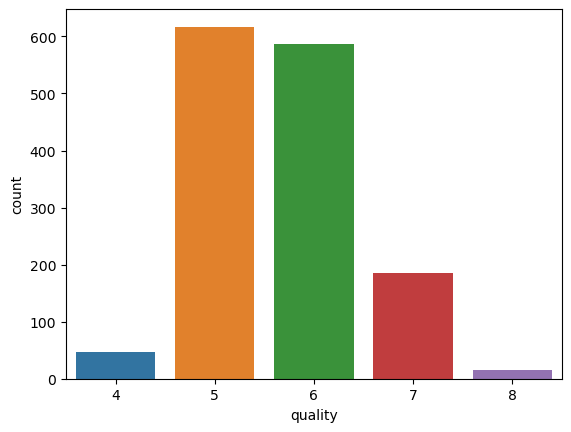

In [15]:
sns.countplot(df_n["quality"])

In [16]:
st=StandardScaler()
st.fit_transform(df_n)

array([[-0.55292997,  1.05091371, -1.39039974, ..., -0.61065143,
        -0.99985592, -0.84412477],
       [-0.3099004 ,  2.11933582, -1.39039974, ...,  0.39101696,
        -0.6081737 , -0.84412477],
       [-0.3099004 ,  1.40705441, -1.18083057, ...,  0.15823656,
        -0.6081737 , -0.84412477],
       ...,
       [-1.22126131, -0.07686519, -0.70929993, ...,  0.89650672,
         0.56687296,  0.43573421],
       [-1.46429088,  0.72445139, -0.76169222, ...,  0.61374608,
        -0.21649148, -0.84412477],
       [-1.40353349, -1.26400088,  1.07203802, ...,  0.23700283,
         0.56687296,  0.43573421]])

In [17]:
dfx=df.iloc[:,0:-1]
dfy=df.iloc[:,-1]

5    681
6    681
7    681
4    681
8    681
3    681
Name: quality, dtype: int64


<AxesSubplot:xlabel='quality', ylabel='count'>

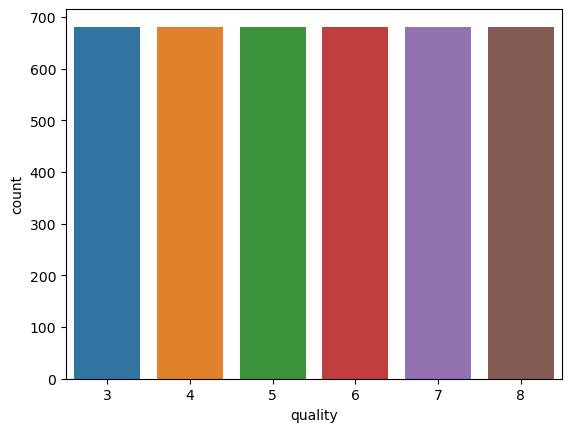

In [18]:
# to balance the output data
smt=SMOTE()
trainx, trainy=smt.fit_resample(dfx,dfy)
print(trainy.value_counts())
sns.countplot(trainy)

In [19]:
x_train,x_test,y_train,y_test=train_test_split(trainx,trainy,test_size=0.25,random_state=15)

In [20]:
lg=LogisticRegression()
gnb=GaussianNB()
svc=SVC()
dtc=DecisionTreeClassifier()
knn=KNeighborsClassifier()

accuracy score for  LogisticRegression() is :  
 0.5048923679060665 
 [[131  10  20   0   0   0]
 [ 36  78  32  12   1   0]
 [ 28  25  83  23   8   4]
 [ 19  31  24  53  18  28]
 [  6   0   2  42  55  74]
 [  0   0   0   3  60 116]] 
               precision    recall  f1-score   support

           3       0.60      0.81      0.69       161
           4       0.54      0.49      0.51       159
           5       0.52      0.49      0.50       171
           6       0.40      0.31      0.35       173
           7       0.39      0.31      0.34       179
           8       0.52      0.65      0.58       179

    accuracy                           0.50      1022
   macro avg       0.49      0.51      0.50      1022
weighted avg       0.49      0.50      0.49      1022
 

accuracy score for  GaussianNB() is :  
 0.5215264187866928 
 [[127   5  14  15   0   0]
 [ 50  72  21  13   3   0]
 [ 21  39  72  18  17   4]
 [ 21  35  21  36  35  25]
 [  2   8   1  24  72  72]
 [  0   0   0   8  17 1

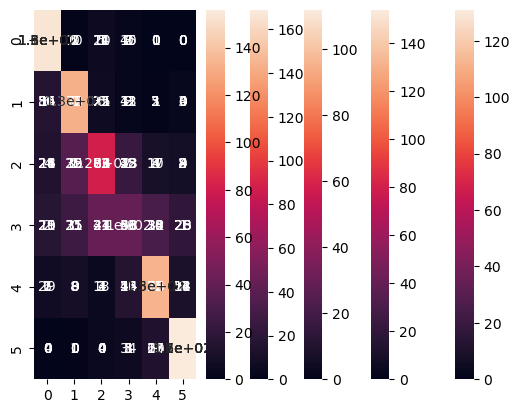

In [21]:
model=[lg,gnb,svc,dtc,knn]
for m in model:
    m.fit(x_train,y_train)
    m.score(x_train,y_train)
    predm=m.predict(x_test)
    print("accuracy score for ",m,"is : ","\n",accuracy_score(y_test,predm),"\n",confusion_matrix(y_test,predm),"\n",classification_report(y_test,predm),"\n")
    sns.heatmap(confusion_matrix(y_test,predm),annot=True)

Decision Tree Classifier gives the best accuracy, so proceeding with that.

In [22]:
from sklearn.model_selection import cross_val_score
score= cross_val_score(dtc,x_train,y_train,cv=5)
score

array([0.77650897, 0.78303426, 0.77487765, 0.80424144, 0.74836601])

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
dict1={"alpha":[0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1]}
gv=GridSearchCV(estimator=ElasticNet(),param_grid=dict1, refit=True)
gv.fit(x_train,y_train)
gv.best_params_

{'alpha': 1e-06}

In [24]:
dtc.fit(x_train,y_train)
pred=dtc.predict(x_test)
accuracy_score(y_test,pred)

0.8023483365949119

In [25]:
from sklearn.metrics import roc_curve,roc_auc_score
import matplotlib.pyplot as plt

In [26]:
y_pred_prob=dtc.predict_proba(x_test)[:,1]

In [27]:
fps,tps,thresholds=roc_curve(y_test,y_pred_prob,pos_label=4)

In [28]:
tps

array([0.        , 0.81132075, 1.        ])

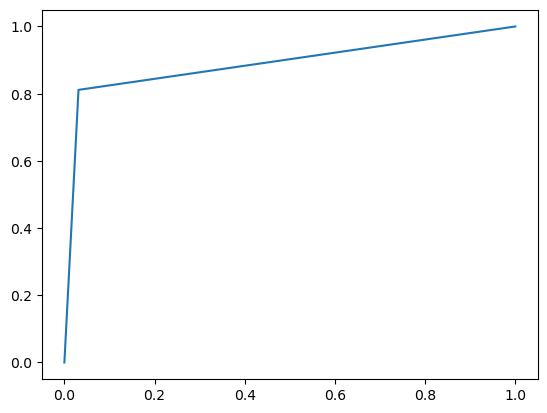

In [29]:
plt.plot(fps,tps,label = "DTC")

In [30]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,RandomForestRegressor

In [31]:
rf=RandomForestClassifier()
ran=[]
for i in range(50):
    ran.append(i)

In [32]:
dict2={"random_state":ran}
gv=GridSearchCV(rf,dict2, refit=True)
gv.fit(x_train,y_train)
gv.best_params_

{'random_state': 46}

In [33]:
rf1=RandomForestClassifier(random_state=22)
rf1.fit(x_train,y_train)
prf=rf1.predict(x_test)
accuracy_score(y_test,prf)

0.8581213307240705

In [55]:
def predict(inplist):
    inp=np.array(inplist)
    i=inp.reshape(1,-1)
    res=rf1.predict(i)
    print(res)
    if res>6:
        print("it is a good quality wine")
    else:
        print("the quality of wine is not good")

In [56]:
#to enter all the values directly here, run this
predict([11.2, 0.28, 0.56, 1.9, 0.075, 17.0, 60.0, 0.998, 3.16, 0.58, 9.8])

[6]
the quality of wine is not good


In [57]:
#to enter values one by one, run this
inplist=[]
vari=["fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol"]
for v in vari:
    n=float(input(f"enter the value for {v} :  "))
    inplist.append(n)
    
predict(inplist)

enter the value for fixed acidity :  11.2
enter the value for volatile acidity :  0.28
enter the value for citric acid :  0.56
enter the value for residual sugar :  1.9
enter the value for chlorides :  0.075
enter the value for free sulfur dioxide :  17.0
enter the value for total sulfur dioxide :  60
enter the value for density :  0.998
enter the value for pH :  3.16
enter the value for sulphates :  0.58
enter the value for alcohol :  9.8
[6]
the quality of wine is not good


According to the analysis, citric acid, sulphates and alcohol are the physiochemical properties that makes a wine good.
While total sulphur dioxide and volatile acidity has negative impact on quality of wine.